In [10]:
import os
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf
from pandas.testing import assert_frame_equal

# From TensorFlow
from tensorflow.data.experimental import AUTOTUNE
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, RandomRotation
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50V2, EfficientNetB0, EfficientNetB5, EfficientNetB7, DenseNet121, ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, PrecisionAtRecall, SpecificityAtSensitivity, PrecisionAtRecall
from tensorflow.keras.losses import BinaryCrossentropy

# From scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

#set_global_policy('mixed_float16')
set_global_policy('float32')

SEED = 42

# Python's built-in random module
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# GPU Availability

In [11]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants and Hyperparameters

In [20]:
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IM_SIZE = 128
EPOCHS = 60
LEARN_RATE = 0.0001
REG_RATE = 0.001
NEURONS_1 = 1024
NEURONS_2 = 1024
NEURONS_3 = 256
DROPOUT_RATE = 0.5
ACTIVATION = 'relu'
BACKBONE = 'ResNet152V2'
SEED_BALANCED = 7

# Read the dataset
ROOT_DATASET_DIR = "../"
DATASET = os.path.join(ROOT_DATASET_DIR,"images")

# Read the dataset
file_name = os.path.join(".","train-metadata-eda-fe-v3-kaggle.csv")
df = pd.read_csv(file_name)

X = df.drop(['target'], axis=1)
y = df['target']

# Evaluation Functions

In [21]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

# Image Processing Functions

In [28]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image

rotate_image = RandomRotation(factor=0.2)

def random_zoom(image, min_val=0.8, max_val=1.2):
    # Random zoom
    zoom_scale = tf.random.uniform([], minval=min_val, maxval=max_val)
    original_size = tf.shape(image)[0:2]
    new_size = tf.cast(zoom_scale * tf.cast(original_size, tf.float32), tf.int32)
    image = tf.image.resize_with_crop_or_pad(image, new_size[0], new_size[1])
    image = tf.image.resize(image, original_size)
    return image
    
# Function to add Gaussian noise
def gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

def gaussian_blur(image, kernel_size=5, sigma=1.0): 
    kernel = gaussian_kernel(kernel_size, 0.0, sigma)
    image = tf.expand_dims(image, axis=0)
    image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    return tf.squeeze(image, axis=0)
    
# Image augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image) # Vertical flip
    #angle = tf.random.uniform([], minval=-20, maxval=20)
    image = rotate_image(image)
    image = tf.image.random_brightness(image, max_delta=0.5)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)  # Random contrast
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)  # Random saturation
    #image = random_zoom(image, min_val=0.8, max_val=1.2)
    #image = tf.image.random_hue(image, max_delta=0.1)
    #image = gaussian_noise(image, mean=0.0, stddev=0.1) 
    #image = gaussian_blur(image, kernel_size=5, sigma=1.0)
    return image, label

# Parse and process images
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)  # Use a reasonable buffer size
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory):
    data_dir = Path(directory)    
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [0 if '\\0' in str(path) else 1 for path in all_image_paths]
    return all_image_paths, all_labels


def match_image_paths(X_fold, all_image_paths, all_labels):
    # Create a DataFrame for all image paths and labels
    df_all_data = pd.DataFrame({'image_path': all_image_paths, 'label': all_labels})
    df_all_data['isic_id'] = df_all_data['image_path'].str.extract(r'(ISIC_\d+)')

    # Merge on 'isic_id' with a left join
    df_merged = pd.merge(X_fold, df_all_data, on='isic_id', how='left', sort=False).set_index(X_fold.index)

    # Check for missing data in columns that should have been filled from all_data_df
    missing_data = df_merged[df_merged['image_path'].isna() | df_merged['label'].isna()]

    # Check missing data
    assert missing_data.empty, "Missing data found in the following rows:"

    # Ensure that all rows from X_fold have a corresponding entry
    assert len(X_fold) == len(df_merged), "Mismatch in row count after merge"

    assert df_merged.index.equals(X_fold.index), "Index mismatch after merge"
    
    # Return paths and labels
    return df_merged['image_path'].tolist(), df_merged['label'].tolist(), df_merged.index.tolist()

# Class Balance Function

In [23]:
# Function to undersample the majority class and oversample the minority class
def balance_classes(image_paths, labels, majority_size=None, minority_size=None, seed=SEED):
    # Convert to numpy arrays for easier manipulation
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Separate the majority and minority classes
    majority_class = image_paths[labels == 0]
    majority_labels = labels[labels == 0]
    
    minority_class = image_paths[labels == 1]
    minority_labels = labels[labels == 1]
    
    # Undersample the majority class if majority_size is specified
    if majority_size and (majority_size < len(majority_class)):
        majority_class_downsampled, majority_labels_downsampled = resample(
            majority_class,
            majority_labels,
            replace=False,  # Sample without replacement
            n_samples=majority_size,  # Number of samples after undersampling
            random_state=seed  # For reproducibility
        )
    else:
        majority_class_downsampled, majority_labels_downsampled = majority_class, majority_labels
    
    # Oversample the minority class if minority_size is specified
    if minority_size and (minority_size > len(minority_class)):
        minority_class_upsampled, minority_labels_upsampled = resample(
            minority_class,
            minority_labels,
            replace=True,  # Sample with replacement
            n_samples=minority_size,  # Number of samples after oversampling
            random_state=seed  # For reproducibility
        )
    else:
        minority_class_upsampled, minority_labels_upsampled = minority_class, minority_labels
    
    # Combine the undersampled majority class and upsampled minority class
    balanced_image_paths = np.concatenate([majority_class_downsampled, minority_class_upsampled])
    balanced_labels = np.concatenate([majority_labels_downsampled, minority_labels_upsampled])
    
    return balanced_image_paths.tolist(), balanced_labels.tolist()

# Create the CNN

**Note**: This section shows the algorithm used to generate cross-validated CNN predition vector. This structure will be created during a stratifed K-fold cross-validation process to find the best CNN parameters. Predictions will be made out-of-sample using unseen data: for each fold, a CNN model is trained using 4 folds and predictions are made on the remaining fold. This apprach follows the principles to ensure the integrity of the final model avoiding data leakage.

In [24]:
# Function to build the convolutional neural network. Based on ResNet152V2, the whole backbone and hidden layer will be trainen to achieve more accurate predictions
def create_cnn_model():
    
    # Use ResNet152V2 as a backbone
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

    # Enable backbone training
    for layer in base_model.layers:
        layer.trainable = True

    # Generate a neural network with one hidden layer of 64 neurons
    x = GlobalAveragePooling2D()(base_model.output)    
    x = Dense(NEURONS_1, kernel_initializer=glorot_uniform(seed=SEED), activation=ACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE, seed=SEED)(x)
    x = Dense(NEURONS_2, kernel_initializer=glorot_uniform(seed=SEED), activation=ACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE, seed=SEED)(x)
    x = Dense(NEURONS_3, kernel_initializer=glorot_uniform(seed=SEED), activation=ACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE, seed=SEED)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Define optimizer and evaluation metrics
    optimizer = Adam(learning_rate=LEARN_RATE)
    eval_metrics = ["accuracy", AUC(from_logits=False), SpecificityAtSensitivity(sensitivity=0.8)]

    # And compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
    
    return model

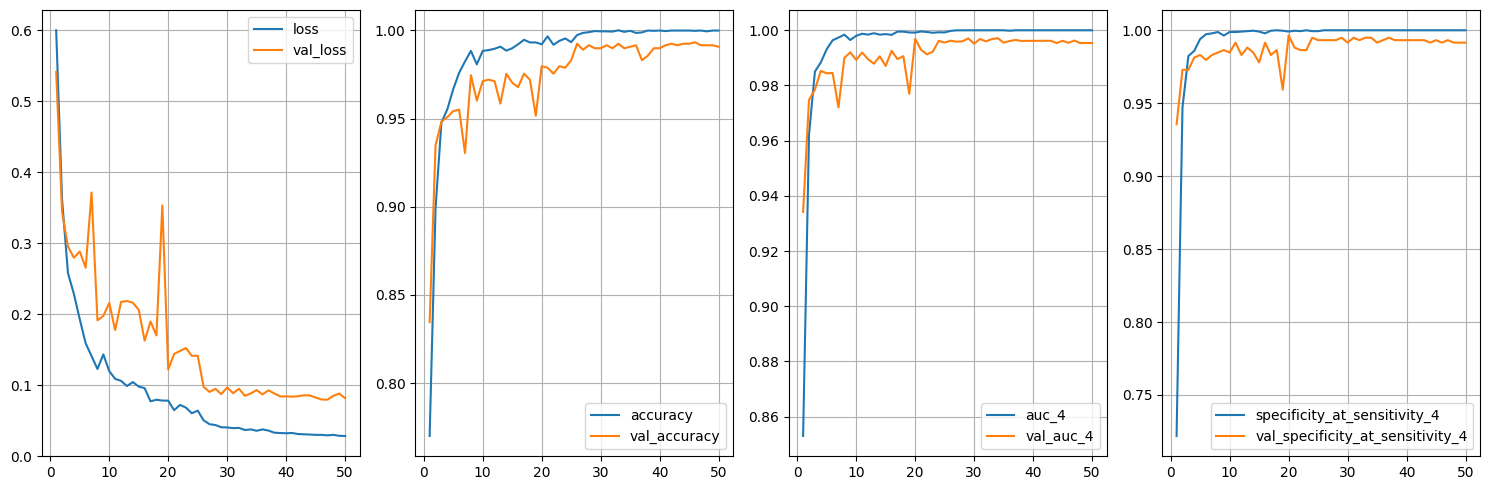

1236/1236 [==============================] - 56s 44ms/step
pAUC: 0.1448519104320426


In [25]:
N_SPLITS = 5
TRAIN_TEST_SPLIT = 0.15

# Split the data into training and validation sets
all_image_paths, all_labels = get_image_paths_and_labels(DATASET + '/crossval')

# Frequencies of class 1 (malign)
n_class_1 = all_labels.count(1)

# Apply stratified K-fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

cancer_prob_list = []
pauc_scores = []
fold = 1

for train_idx, test_idx in skf.split(X, y):

    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Match train and validation images
    image_train_fold, label_train_fold, index_train_fold = match_image_paths(X_train_fold, all_image_paths, all_labels)
    image_test_fold, label_test_fold, index_test_fold = match_image_paths(X_test_fold, all_image_paths, all_labels)
    
    assert (test_idx == index_test_fold).all(), "indexes are not the same"
    assert (y_test_fold.tolist() == label_test_fold), "y_tests are not the same"
    
    # Balance the classes by undersampling and oversampling
    image_train_fold_balanced, label_train_fold_balanced = balance_classes(        
        image_train_fold, 
        label_train_fold, 
        majority_size=n_class_1 * 10,  # Set this to the desired number of majority samples
        minority_size=n_class_1 * 10,   # Set this to the desired number of minority samples
        seed=SEED_BALANCED
    )

    # Split the data into training and validation sets.
    # The validation set will be use to control the training process
    train_paths, validation_paths, train_labels, validation_labels = train_test_split(
        image_train_fold_balanced,
        label_train_fold_balanced, 
        test_size=TRAIN_TEST_SPLIT,
        stratify=label_train_fold_balanced, 
        random_state=SEED)

    # Train CNN on the training fold
    train_dataset =      generate_dataset(train_paths, train_labels, BATCH_SIZE, is_training=True)
    validation_dataset = generate_dataset(validation_paths, validation_labels, BATCH_SIZE, is_training=False)
    test_dataset =       generate_dataset(image_test_fold, label_test_fold, BATCH_SIZE, is_training=False)

    with tf.device('/GPU:0'):

        # Create and compile the CNN model
        cnn_model = create_cnn_model()

        # Enable reducing learning rate on plateau
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=1e-7)

        filepath=f"tmp.keras"
        checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)

        # Train the model on the current fold
        cnn_model.fit(
            train_dataset,
            batch_size=BATCH_SIZE,    
            epochs=EPOCHS,
            verbose=1,
            validation_data=validation_dataset,    
            callbacks=[plot_learning(), reduce_lr_callback, checkpoint_callback]
        )

    # Load best model
    cnn_model = load_model(filepath)

    # Predict on the remaining
    cancer_prob = cnn_model.predict(test_dataset)

    pauc = partial_auc_score(y_test_fold, cancer_prob)
    pauc_scores.append(pauc)
    print(f'pAUC: {pauc}', flush=True)

    # Store the features along with the corresponding indices
    cancer_prob_list.append((test_idx, cancer_prob, pauc))

    fold += 1

In [26]:
# Create the cross-validated CNN feature vector.
cancer_prob_all = np.zeros((len(X), cancer_prob_list[0][1].shape[1]))  # Initialize full feature matrix
merged_list = []
fold = 1

# Loop over the cancer probability list
for test_idx, cancer_prob, pauc in cancer_prob_list:
    assert len(test_idx) == len(cancer_prob), "error"
    cancer_prob_all[test_idx] = cancer_prob
    print(f"Partial AUC score for fold {fold}: {pauc}")
    fold += 1
    
df_cnn = pd.DataFrame({'crossval_cnn_preds': cancer_prob_all.flatten()})
df_cnn = pd.concat([df[['isic_id']], df_cnn, df[['target']]], axis=1)
df_cnn.to_csv(f"train-cnn-crossval-preds-{BACKBONE}_{IM_SIZE}_seed{SEED_BALANCED}.csv", index=False)

Partial AUC score for fold 1: 0.13540689771006947
Partial AUC score for fold 2: 0.15150875588060597
Partial AUC score for fold 3: 0.13884559180124037
Partial AUC score for fold 4: 0.14398020905769504
Partial AUC score for fold 5: 0.1448519104320426
